# **Set up**

Please follow the instructions from README.md to set up the virtual environment. Make sure when you run the notebook you are using the kernel you set up which uses the virtual environment.

Learning materials:
* Tensorflow: <https://www.youtube.com/playlist?list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S>
* Explanation: <https://www.youtube.com/watch?v=GGLr-TtKguA&t=2275s>

## **Import packages**

In [64]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
from nltk.probability import FreqDist
import tensorflow as tf
# from tqdm import tqdm
# import pickle, argparse, os
# import data_analysis as da
# import shutil, traceback

# # data processing
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.metrics import accuracy_score, classification_report

# # Hugging Face
# import torch
# from transformers import Trainer, TrainingArguments
# from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, BertModel
# from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertConfig

# from torch.cuda.amp import autocast, GradScaler
# from torch.nn.functional import softmax
# from torch.utils.data import DataLoader, TensorDataset

import seaborn as sns
# import re
# from pandasql import sqldf
# import os
# import textwrap
# from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LinearSegmentedColormap



In [2]:
import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')
common_stopwords = stopwords.words('english')
print(common_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shiha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Datasets**

In [3]:
datastore = []
with open("./Sarcasm_Headlines_Dataset.json/Sarcasm_Headlines_Dataset.json", "r") as f:
    for line in f:
        datastore.append(json.loads(line))

In [74]:
sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [5]:
print("Number of sentences: ", str(len(sentences)))
print("Number of labels: ", str(len(labels)))

Number of sentences:  26709
Number of labels:  26709


# **Explorative Data Analysis**

In [6]:
sentences_df = pd.DataFrame({"headline":sentences,
                             "is_sarcastic":labels
                            })
sentences_df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


**Here we take a look at the overall percentage of sarcastic headlines. In this dataset, the distribution of 1 and 0 is relatively even. Here we do not have imbalanced dataset problem.**

In [7]:
overview_df = sentences_df.groupby("is_sarcastic").agg({"headline":"count"}).reset_index(drop=False)
overview_df['percentage'] = round(overview_df['headline']*100/overview_df['headline'].sum(),1)
overview_df

,is_sarcastic,headline,percentage
0,0,14985,56.1
1,1,11724,43.9


## **Number of words**

Here we take a look at the number of words in each sentence (can think of it as "document").

We also explore if the number of words have different distributions between Sarcastic and Non Sarcastic headlines.

In [8]:
sentences_df["number_of_words"] = sentences_df['headline'].apply(lambda x: len(x.split()))

<Axes: >

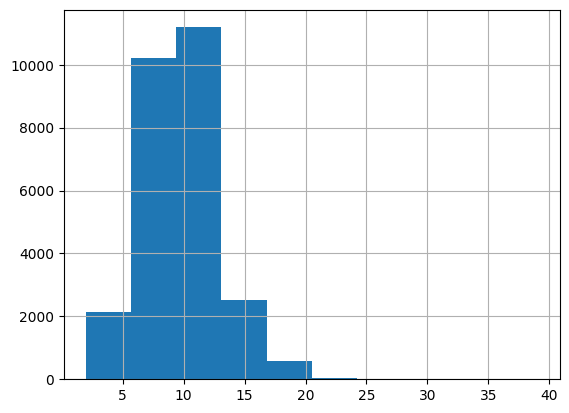

In [9]:
sentences_df["number_of_words"].hist()

In [10]:
# sentences_df.hist("number_of_words", by ="is_sarcastic" )

In [11]:
sentences_df["number_of_words"].describe()

count    26709.000000
mean         9.845820
std          3.168955
min          2.000000
25%          8.000000
50%         10.000000
75%         12.000000
max         39.000000
Name: number_of_words, dtype: float64

In [12]:
sentences_df["number_of_words"].max()

39

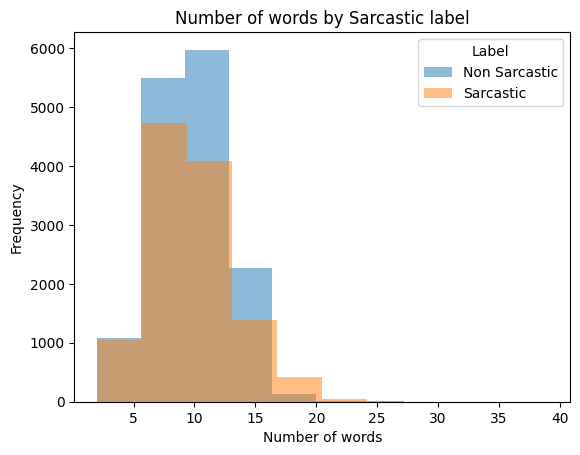

In [13]:
plt.hist(sentences_df[sentences_df["is_sarcastic"]==0]["number_of_words"], alpha=0.5, label='Non Sarcastic')
plt.hist(sentences_df[sentences_df["is_sarcastic"]==1]["number_of_words"], alpha=0.5, label='Sarcastic')
#add plot title and axis labels
plt.title('Number of words by Sarcastic label')
plt.xlabel('Number of words')
plt.ylabel('Frequency')

#add legend
plt.legend(title='Label')

#display plot
plt.show()

## **Top appearing words**

In [14]:
def extract_top_n_words(title_list, n=10):
    fdist = FreqDist(title_list)
    top_n = fdist.most_common(n)
    return top_n

In [15]:
all_words_list = [xx for x in sentences for xx in x.split() if xx not in common_stopwords]
all_top_n_words = extract_top_n_words(all_words_list)
all_top_n_words

[('new', 1485),
 ('man', 1229),
 ('trump', 1157),
 ('one', 487),
 ('area', 484),
 ('donald', 468),
 ('says', 450),
 ('woman', 420),
 ('u.s.', 410),
 ('day', 391)]

In [37]:
num_unique_words = len(set(all_words_list))
num_unique_words

36445

**We check if the top appearing words could be different for different labels**

In [16]:
sarcastic_headlines = list(sentences_df[sentences_df['is_sarcastic']==1]['headline'])
non_sarcastic_headlines = list(sentences_df[sentences_df['is_sarcastic']==0]['headline'])

In [17]:
sarcastic_words_list = [xx for x in sarcastic_headlines for xx in x.split() if xx not in common_stopwords]
sarcastic_top_n_words = extract_top_n_words(sarcastic_words_list)
sarcastic_top_n_words

[('man', 1021),
 ('new', 821),
 ('area', 477),
 ('report:', 360),
 ('woman', 290),
 ('one', 253),
 ('time', 213),
 ('still', 208),
 ('day', 207),
 ('trump', 200)]

In [18]:
non_sarcastic_words_list = [xx for x in non_sarcastic_headlines for xx in x.split() if xx not in common_stopwords]
non_sarcastic_top_n_words = extract_top_n_words(non_sarcastic_words_list)
non_sarcastic_top_n_words

[('trump', 957),
 ('new', 664),
 ('donald', 453),
 ("trump's", 364),
 ('says', 346),
 ('women', 240),
 ('one', 234),
 ('u.s.', 223),
 ('first', 220),
 ('make', 209)]

In [75]:
group_by = 'is_sarcastic'
summary_key_words_by_label = pd.DataFrame()
labels_plot = list(sentences_df[group_by].unique())
for label in labels_plot:
    headline_label_list = list(sentences_df[sentences_df[group_by] == label]['headline'])
    headline_label_list_words = [xx for x in headline_label_list for xx in x.split() if xx not in common_stopwords]
    top_n_words = extract_top_n_words(headline_label_list_words)
    for i in range(len(top_n_words)):
        new_row = pd.DataFrame({group_by: [label],
                                "word": [top_n_words[i][0]],
                                "count": [top_n_words[i][1]]})
        summary_key_words_by_label = pd.concat([summary_key_words_by_label, new_row])

Text(0.5, 1.0, 'Word Count by is_sarcastic')

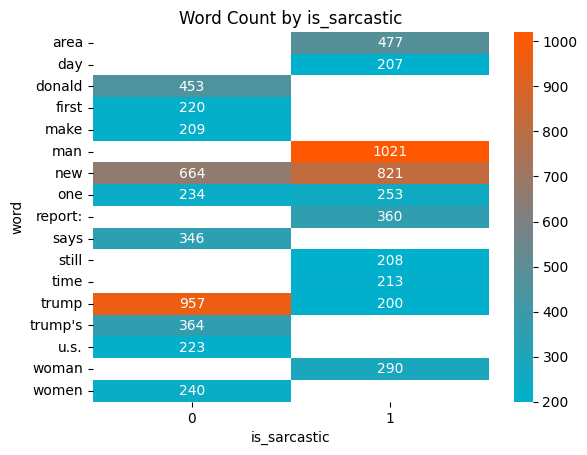

In [76]:
pivot_df = summary_key_words_by_label.pivot(index="word", columns=group_by, values="count")
# Create a custom colormap
colors = ["#00b0cc", "grey", "#FF5800"]  # Define the colors
n_bins = 100  # Increase this number for a smoother transition
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)
sns.heatmap(pivot_df, annot=True, fmt='.0f', cmap=cmap)
plt.title("Word Count by " + group_by)

From the plot above we can see for example for headlines being Sarcastic, the distinct words include "area", "day", "man", "report:", "still", "time", "woman". However do note that words "woman" and "women" share the same context. There's another observation that "trump" appears often in the headlines. This triggers the question about whether or not we should remove these top appearing words in general as they could appear in headlines quite often, they could be ineffective in determining whether or not the headline is sarcastic. 

# Data Processing

## Descriptions

**In general, we need to clean the text before we make it into tokens. Common steps include:**
- Lower case
- Remove trailing or leading spaces
- Remove hyper links
- Remove punctuations (?)

**Further, the words are tokenized into numbers. Basically this step is to convert the data into a format that the model understand - i.e. numerical format**

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Train and test split

We don't want the model to see anything from the test set when it is training. If we really want to test its effectiveness - make sure the neural net only sees the training data. **Therefore** we split into train and test before tokenizing.

In [57]:
train_ratio = 0.8
training_size = int(round(len(sentences)*train_ratio,0))
print(training_size)

vocab_size = 10000
embedding_dim = 16
max_length = 40
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

21367


In [78]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [79]:
print("Training obs:", len(training_sentences))
print("Testing obs:", len(testing_sentences))
print("Total obs:", len(training_sentences)+len(testing_sentences))
print("Total obs from original:", len(sentences))

Training obs: 21367
Testing obs: 5342
Total obs: 26709
Total obs from original: 26709


## Tokenizing with tokenizer 

- Initiate tokenizer with *Tokenizer*
- Use method *fit_on_texts* to convert words into indexes, this is like creating a dictionary
- Then convert the training_sentences into training sequences (number format) using *tokenizer.texts_to_sequences()*
- Also pad the sequences using *pad_sequences()*

In [80]:
tokenizer_all = Tokenizer(oov_token=oov_tok)
tokenizer_all.fit_on_texts(sentences)
word_index_all = tokenizer_all.word_index

In [81]:
tokenizer = Tokenizer(oov_token=oov_tok)

In [82]:
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

In [83]:
print("Number of words tokenized:", len(word_index)-1)
print("Number of original words tokenized", len(word_index_all)-1)

Number of words tokenized: 26506
Number of original words tokenized 29656


In [84]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, padding=padding_type, 
                                truncating=trunc_type, maxlen=max_length)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, padding=padding_type, 
                               truncating=trunc_type, maxlen=max_length)



training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)


In [85]:
training_labels

array([0, 0, 1, ..., 0, 1, 1])

**Note that we have chosen "post" padding, meaning adding 0's to the end of the sentence if it is less than 40 characters. As shown above, the maximum number of words in the headlines is 40 and therefore headlines less than 40 words will be padded. QUESTION: is it because we have added OOV and so the length increased from 39 to 40?**

See documentation here: <https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences>

In [86]:
training_sentences[1]

"the 'roseanne' revival catches up to our thorny political mood, for better and worse"

In [87]:
training_sequences[0]

[320, 13336, 681, 3589, 2357, 46, 381, 2358, 13337, 6, 2750, 9270]

In [88]:
training_padded[0]

array([  320, 13336,   681,  3589,  2357,    46,   381,  2358, 13337,
           6,  2750,  9270,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0])

In [91]:
print("Number of unique words including <OOV> in training:", str(len(word_index)))
print("Number of observations with the number of 'features' after padding in training:", training_padded.shape)

Number of unique words including <OOV> in training: 26507
Number of observations with the number of 'features' after padding in training: (21367, 40)


## Embeddings
- This step is to understand the context and relationships between words. Words that only appear in the Sarcastic headlines would have a strong components in the Sarcastic direction.
- The neural net can learn from the training process which words are more on the Sarcastic side and which are not
- After the full training, the values are "added" together

In [92]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim), # Learning the meaning and context epoch by epoch
    tf.keras.layers.GlobalAveragePooling1D(), # Sum up the vectors - adding the vectors
    tf.keras.layers.Dense(24, activation='relu'), # activation 
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [67]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [112]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
668/668 - 2s - 2ms/step - accuracy: 0.9925 - loss: 0.0228 - val_accuracy: 0.7845 - val_loss: 1.6093
Epoch 2/30
668/668 - 3s - 4ms/step - accuracy: 0.9860 - loss: 0.0383 - val_accuracy: 0.8077 - val_loss: 1.2718
Epoch 3/30
668/668 - 2s - 2ms/step - accuracy: 0.9914 - loss: 0.0253 - val_accuracy: 0.8036 - val_loss: 1.3046
Epoch 4/30
668/668 - 2s - 2ms/step - accuracy: 0.9941 - loss: 0.0187 - val_accuracy: 0.8066 - val_loss: 1.3452
Epoch 5/30
668/668 - 3s - 4ms/step - accuracy: 0.9892 - loss: 0.0289 - val_accuracy: 0.8019 - val_loss: 1.3863
Epoch 6/30
668/668 - 2s - 2ms/step - accuracy: 0.9951 - loss: 0.0161 - val_accuracy: 0.8046 - val_loss: 1.4217
Epoch 7/30
668/668 - 1s - 2ms/step - accuracy: 0.9940 - loss: 0.0170 - val_accuracy: 0.8031 - val_loss: 1.4270
Epoch 8/30
668/668 - 1s - 2ms/step - accuracy: 0.9941 - loss: 0.0181 - val_accuracy: 0.8059 - val_loss: 1.4633
Epoch 9/30
668/668 - 1s - 2ms/step - accuracy: 0.9927 - loss: 0.0209 - val_accuracy: 0.8091 - val_loss: 1.5734
E

In [99]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 40, 16)              │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 16)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 24)                  │             408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 481,301 (1.84 MB)

 Trainable params: 160,433 (626.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 320,868 (1.22 MB)

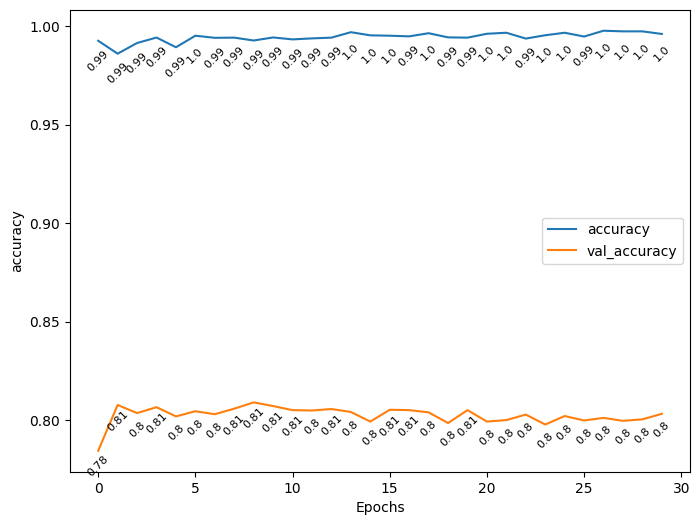

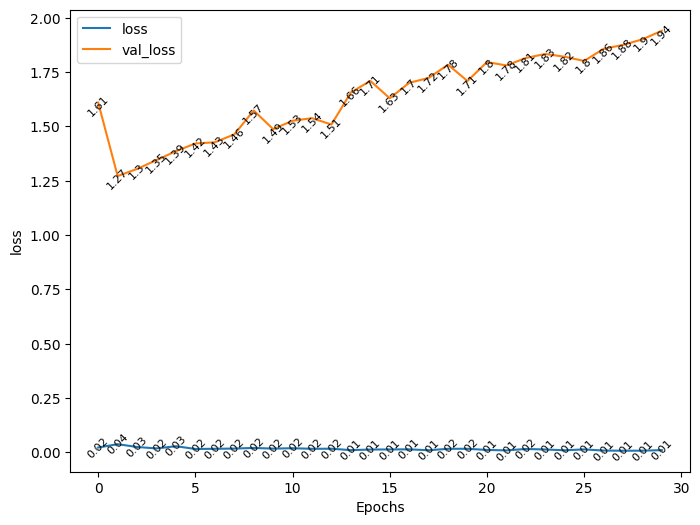

In [139]:
def plot_graphs(history, string):
    plt.figure(figsize=(8,6))

    total_epochs = len(history.history[string])
    epochs = [i for i in range(total_epochs)]
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])

    # Add data labels to each point
    for i, j in zip(epochs, history.history[string]):
        plt.text(i, j*0.99, f'{round(j,2)}', ha='center', va='center',fontsize=8,rotation=45)

    # Add data labels to each point
    for i, j in zip(epochs, history.history['val_'+string]):
        plt.text(i, j*0.99, f'{round(j,2)}', ha='center', va='center',fontsize=8,rotation=45)
    
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [101]:
new_sentences = ["granny starting to fear spiders in the garden might be real",
            "game of thrones season finale showing this sunday night"]
new_sequences = tokenizer.texts_to_sequences(new_sentences)
new_padded = pad_sequences(new_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(new_padded))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
[[9.6433806e-01]
 [5.7134882e-04]]


# Recurrent Neural Network

- Understanding sequences - we can think of the model as taking f(Data, Label) which is the rule -> think of the $n_x=n_{x-1} + n_{x-2}$
- The numerical values can remain in the sequence for example
- The recurrent neuron takes values sequentially while remaining the outputs from previous neurons
- This weakens as time goes by -> helpful when required context is closeby
- There could be problems where we need longer memory

# Long Short Term Memory (LSTM)
* An architextual that has "context" which can bring the meaning from the beginning of the sentence
* It could be bidirectional! Words from future can give you context of current word. For more leanrning <deeplearning.ai >

In [105]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim), # Learning the meaning and context epoch by epoch
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), # Sum up the vectors - adding the vectors
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'), # activation 
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [106]:
lstm_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [141]:
num_epochs = 10
lstm_history = lstm_model.fit(training_padded, training_labels, epochs=num_epochs,
                        validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
668/668 - 16s - 25ms/step - accuracy: 0.9903 - loss: 0.0290 - val_accuracy: 0.8330 - val_loss: 0.7099
Epoch 2/10
668/668 - 16s - 24ms/step - accuracy: 0.9929 - loss: 0.0236 - val_accuracy: 0.8377 - val_loss: 0.7067
Epoch 3/10
668/668 - 16s - 24ms/step - accuracy: 0.9944 - loss: 0.0171 - val_accuracy: 0.8330 - val_loss: 0.8597
Epoch 4/10
668/668 - 16s - 24ms/step - accuracy: 0.9964 - loss: 0.0106 - val_accuracy: 0.8280 - val_loss: 0.9904
Epoch 5/10
668/668 - 16s - 25ms/step - accuracy: 0.9959 - loss: 0.0123 - val_accuracy: 0.8293 - val_loss: 1.0388
Epoch 6/10
668/668 - 16s - 25ms/step - accuracy: 0.9955 - loss: 0.0122 - val_accuracy: 0.8282 - val_loss: 1.1263
Epoch 7/10
668/668 - 16s - 24ms/step - accuracy: 0.9965 - loss: 0.0098 - val_accuracy: 0.8315 - val_loss: 1.0643
Epoch 8/10
668/668 - 16s - 25ms/step - accuracy: 0.9976 - loss: 0.0079 - val_accuracy: 0.8323 - val_loss: 1.0570
Epoch 9/10
668/668 - 16s - 24ms/step - accuracy: 0.9970 - loss: 0.0088 - val_accuracy: 0.8311 - 

In [143]:
lstm_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 40, 16)              │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 40, 128)             │          41,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 24)                  │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 732,821 (2.80 MB)

 Trainable params: 244,273 (954.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 488,548 (1.86 MB)

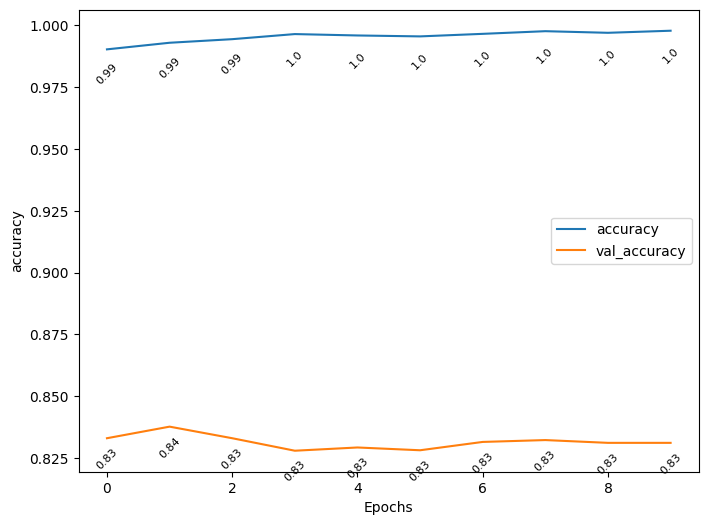

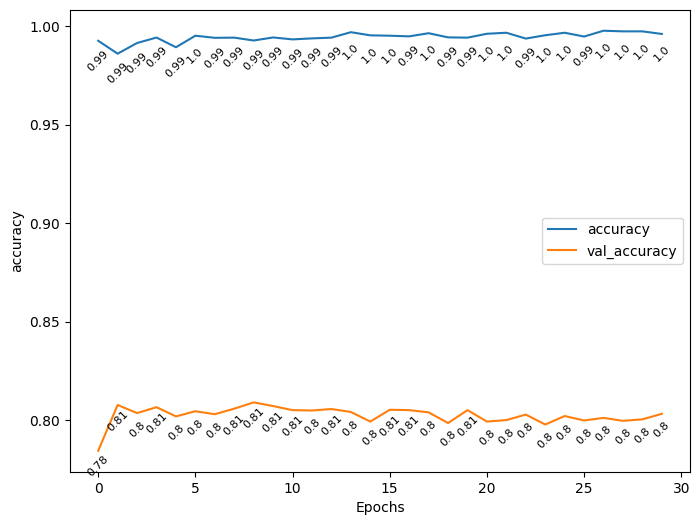

In [144]:
plot_graphs(lstm_history, "accuracy")
plot_graphs(history, "accuracy")